In [1]:
import pandas as pd
from scipy import stats
import numpy as np
import collections
from scipy.stats.stats import pearsonr
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from TumorDecon_Functions import *

### Read data

In [2]:
# Mixture data

df = pd.read_csv('Data/CIBERSORTx_wholeblood_n=12/GSE127813_Whole_blood_gene_expression_matrix.txt', sep='\t')
df.drop_duplicates(subset='GeneSym', inplace=True)
df.set_index('GeneSym', inplace=True)

In [3]:
# Ground truth fractions

exp_freqs = pd.read_csv('Data/CIBERSORTx_wholeblood_n=12/Fig2b_ground_truth_whole_blood.txt', sep='\t')
exp_freqs.set_index('samples', inplace=True)

### Results with LM22

In [4]:
# Signature matrix

lm22 = pd.read_csv('Data/LM22/LM22.txt', sep='\t')
lm22.set_index('Gene symbol', inplace=True)
signature_df = lm22

In [5]:
# Gene sets

gene_set_df = pd.read_csv('Data/LM22/Up_genes.csv')
gene_set_df.drop('Unnamed: 0', axis=1, inplace=True)

gene_sets = {}
for cell in gene_set_df.columns:
    gene_sets[cell] = gene_set_df[cell].dropna()

In [6]:
B_arr = ['B cells naive', 'B cells memory']
T_CD4_arr = ['T cells CD4 naive', 'T cells CD4 memory resting', 'T cells CD4 memory activated']
T_arr = ['T cells CD8', 'T cells CD4 naive', 'T cells CD4 memory resting', 'T cells CD4 memory activated', 
         'T cells follicular helper', 'T cells regulatory (Tregs)', 'T cells gamma delta']
NK_arr = ['NK cells resting', 'NK cells activated']

def add_columns(df):
    df['B cells'] = df[B_arr].sum(axis=1)
    df['T cells CD4'] = df[T_CD4_arr].sum(axis=1)
    df['T cells'] = df[T_arr].sum(axis=1)
    df['NK cells'] = df[NK_arr].sum(axis=1)
#     df['Macrophages'] = df[M_arr].sum(axis=1)
#     df['DC'] = df[DC_arr].sum(axis=1)
    return df

In [7]:
cell_types = ['Neutrophils', 'Monocytes', 'T cells', 'T cells CD8', 'T cells CD4', 'B cells', 'NK cells']
non_overlap = ['Neutrophils', 'Monocytes', 'T cells CD8', 'T cells CD4', 'B cells', 'NK cells']

In [8]:
def get_results_lm22(signature_df, df, gene_sets, exp_freqs, cell_types):
    
    Decon_freqs = pd.read_csv('Results/CIBERSORTx_wholeblood_n=12/R_Decon_freqs.csv')
    Decon_freqs.drop('Unnamed: 0', axis=1, inplace=True)
    Decon_freqs.set_index('col_names', inplace=True)
    Decon_freqs.columns = signature_df.columns

    CIBERSORT_freqs = pd.read_csv('Results/CIBERSORTx_wholeblood_n=12/CIBERSORT_freqs.csv')
    CIBERSORT_freqs.set_index('Input Sample', inplace=True)

    ssGSEA_scores = pd.read_csv('Results/CIBERSORTx_wholeblood_n=12/R_ssGSEA_scores.csv')
    ssGSEA_scores.set_index('Unnamed: 0', inplace=True)
    ssGSEA_scores = ssGSEA_scores.T
    ssGSEA_scores.columns = signature_df.columns
    
    sing_scores = sing_score(df, gene_sets)
    
    CIBERSORTx_freqs_Bmode = pd.read_csv('Results/CIBERSORTx_wholeblood_n=12/CIBERSORTx_freqs_Bmode.csv')
    CIBERSORTx_freqs_Bmode.set_index('Mixture', inplace=True)
    
    CIBERSORTx_freqs_Smode = pd.read_csv('Results/CIBERSORTx_wholeblood_n=12/CIBERSORTx_freqs_Smode.csv')
    CIBERSORTx_freqs_Smode.set_index('Mixture', inplace=True)
    
    Decon_freqs = add_columns(Decon_freqs)
    CIBERSORT_freqs = add_columns(CIBERSORT_freqs)
    ssGSEA_scores = add_columns(ssGSEA_scores)
    sing_scores = add_columns(sing_scores)
    CIBERSORTx_freqs_Bmode = add_columns(CIBERSORTx_freqs_Bmode)
    CIBERSORTx_freqs_Smode = add_columns(CIBERSORTx_freqs_Smode)

    methods = ['DeconRNASeq', 'CIBERSORT', 'ssGSEA', 'singscore', 'CIBERSORTx_Bmode', 'CIBERSORTx_Smode']
    results = {'DeconRNASeq': Decon_freqs, 
               'CIBERSORT': CIBERSORT_freqs, 
               'ssGSEA': ssGSEA_scores, 
               'singscore': sing_scores, 
               'CIBERSORTx_Bmode': CIBERSORTx_freqs_Bmode,
               'CIBERSORTx_Smode': CIBERSORTx_freqs_Smode} 

    p_corr_per_cell, p_corr_per_sample, s_corr_per_cell, s_corr_per_sample = corr_table(methods, results, cell_types, exp_freqs)
    
    return p_corr_per_cell, p_corr_per_sample, s_corr_per_cell, s_corr_per_sample, results

In [9]:
p_corr_per_cell, p_corr_per_sample, s_corr_per_cell, s_corr_per_sample, results = get_results_lm22(signature_df, df, gene_sets, exp_freqs, cell_types)

In [10]:
color_map = {
    'Neutrophils': 'gold',
    'Monocytes': 'yellowgreen',
    'T cells': 'darkcyan',
    'T cells CD8': 'slategrey',
    'T cells CD4': 'skyblue',
    'T cells CD4 naive': 'lightsteelblue',
    'T cells CD4 memory resting': 'cornflowerblue',
    'T cells CD4 memory activated': 'royalblue',
    'T cells gamma delta': 'orange',
    'B cells': 'lightcoral',
    'B cells naive': 'tomato',
    'B cells memory': 'lightsalmon',
    'NK cells': 'mediumorchid'
}

this_color = []
for cell in cell_types:
    this_color.append(color_map[cell])

stack_barchart_color = []
for cell in non_overlap:
    stack_barchart_color.append(color_map[cell])

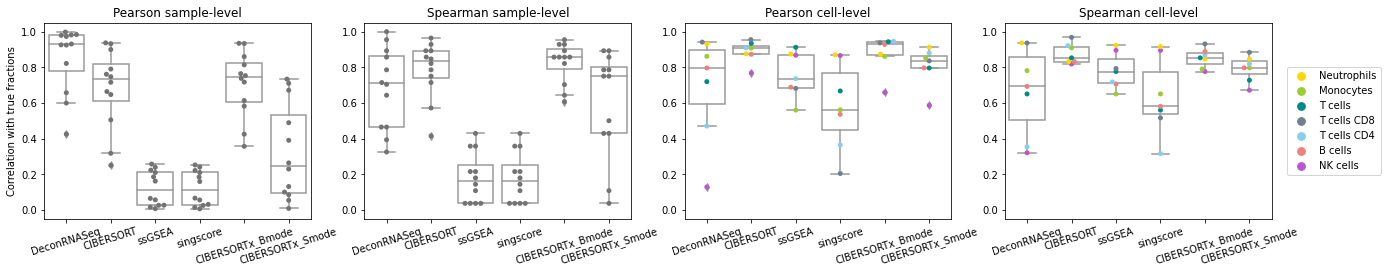

In [11]:
methods = ['DeconRNASeq', 'CIBERSORT', 'ssGSEA', 'singscore', 'CIBERSORTx_Bmode', 'CIBERSORTx_Smode']
corr_boxplot(methods, p_corr_per_sample, s_corr_per_sample, p_corr_per_cell, s_corr_per_cell, (22,10), this_color, 'Corr_wholeblood')

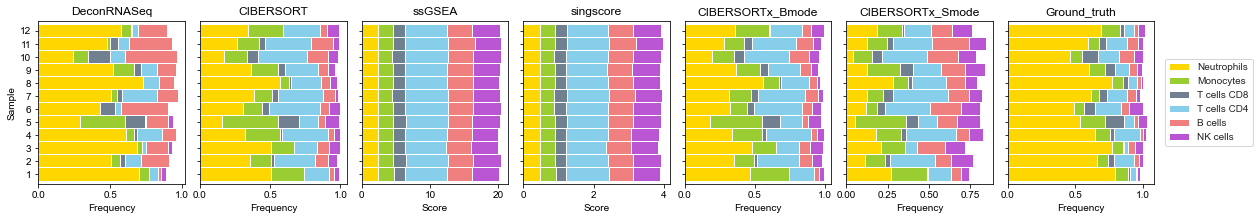

In [12]:
stack_barchart(methods, results, exp_freqs, non_overlap, stack_barchart_color, (20,3), 'barchart_wholeblood')

### Results with LM6

In [13]:
# Signature matrix

lm6 = pd.read_csv('Data/LM6/LM6.txt', sep='\t')
lm6.set_index('NAME', inplace=True)
signature_df = lm6

In [14]:
# Gene sets

gene_set_df = pd.read_csv('Data/LM6/Up_genes.csv')
gene_set_df.drop('Unnamed: 0', axis=1, inplace=True)

gene_sets = {}
for cell in gene_set_df.columns:
    gene_sets[cell] = gene_set_df[cell].dropna()

In [15]:
T_arr = ['CD8 T cells', 'CD4 T cells']

def add_columns(df):
    df['T cells'] = df[T_arr].sum(axis=1)
    df.rename(columns={'CD8 T cells': 'T cells CD8', 'CD4 T cells': 'T cells CD4'}, inplace=True)
    return df

In [16]:
cell_types = ['Neutrophils', 'Monocytes', 'T cells', 'T cells CD8', 'T cells CD4', 'B cells', 'NK cells']
non_overlap = ['Neutrophils', 'Monocytes', 'T cells CD8', 'T cells CD4', 'B cells', 'NK cells']

In [17]:
def get_results_lm6(signature_df, df, gene_sets, exp_freqs, cell_types=None):
    
    Decon_freqs = pd.read_csv('Results/CIBERSORTx_wholeblood_n=12/LM6_R_Decon_freqs.csv')
    Decon_freqs.drop('Unnamed: 0', axis=1, inplace=True)
    Decon_freqs.set_index('col_names', inplace=True)
    Decon_freqs.columns = signature_df.columns

    CIBERSORT_freqs = pd.read_csv('Results/CIBERSORTx_wholeblood_n=12/LM6_CIBERSORT_freqs.csv')
    CIBERSORT_freqs.set_index('Input Sample', inplace=True)

    ssGSEA_scores = pd.read_csv('Results/CIBERSORTx_wholeblood_n=12/LM6_R_ssGSEA_scores.csv')
    ssGSEA_scores.set_index('Unnamed: 0', inplace=True)
    ssGSEA_scores = ssGSEA_scores.T
    ssGSEA_scores.columns = signature_df.columns
    
    sing_scores = sing_score(df, gene_sets)
    
    CIBERSORTx_freqs_Bmode = pd.read_csv('Results/CIBERSORTx_wholeblood_n=12/LM6_CIBERSORTx_freqs_Bmode.csv')
    CIBERSORTx_freqs_Bmode.set_index('Mixture', inplace=True)
    
    Decon_freqs = add_columns(Decon_freqs)
    CIBERSORT_freqs = add_columns(CIBERSORT_freqs)
    ssGSEA_scores = add_columns(ssGSEA_scores)
    sing_scores = add_columns(sing_scores)
    CIBERSORTx_freqs_Bmode = add_columns(CIBERSORTx_freqs_Bmode)

    methods = ['DeconRNASeq', 'CIBERSORT', 'ssGSEA', 'singscore', 'CIBERSORTx_Bmode']
    results = {'DeconRNASeq': Decon_freqs, 
               'CIBERSORT': CIBERSORT_freqs, 
               'ssGSEA': ssGSEA_scores, 
               'singscore': sing_scores, 
               'CIBERSORTx_Bmode': CIBERSORTx_freqs_Bmode} 

    if not cell_types: cell_types = exp_freqs.columns
    p_corr_per_cell, p_corr_per_sample, s_corr_per_cell, s_corr_per_sample = corr_table(methods, results, cell_types, exp_freqs)
    
    return p_corr_per_cell, p_corr_per_sample, s_corr_per_cell, s_corr_per_sample, results

In [18]:
p_corr_per_cell, p_corr_per_sample, s_corr_per_cell, s_corr_per_sample, results = get_results_lm6(signature_df, df, gene_sets, exp_freqs, cell_types)

C:\Users\Trang Le\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Trang Le\Anaconda3\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [19]:
this_color = []
for cell in cell_types:
    this_color.append(color_map[cell])

stack_barchart_color = []
for cell in non_overlap:
    stack_barchart_color.append(color_map[cell])

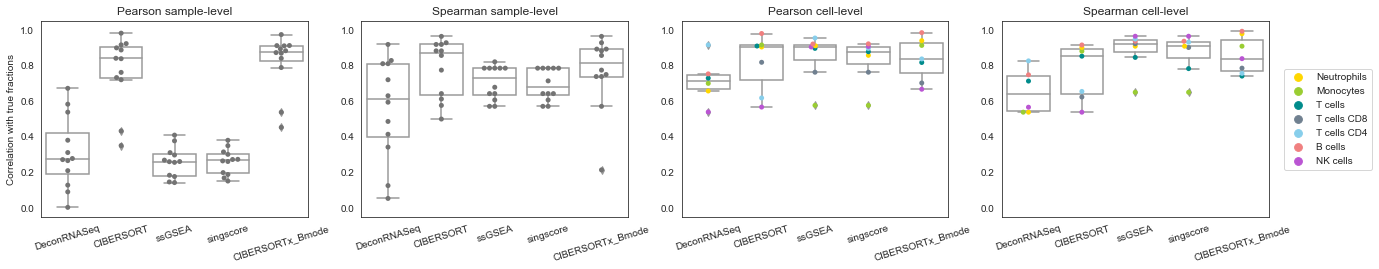

In [20]:
methods = ['DeconRNASeq', 'CIBERSORT', 'ssGSEA', 'singscore', 'CIBERSORTx_Bmode']
corr_boxplot(methods, p_corr_per_sample, s_corr_per_sample, p_corr_per_cell, s_corr_per_cell, (22,10), this_color, 'LM6_Corr_wholeblood')

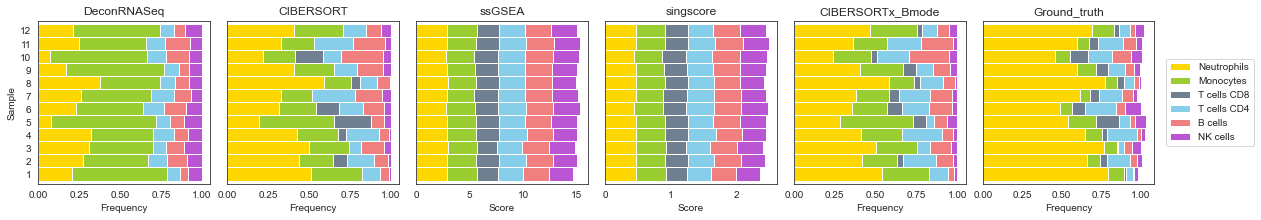

In [21]:
stack_barchart(methods, results, exp_freqs, non_overlap, stack_barchart_color, (20,3), 'LM6_barchart_wholeblood')